(6)=
# Chapter 6: Signal & Noise

In [ ]:
%config InlineBackend.figure_format = 'svg'

When collecting data from a scientific instrument, a measurement is returned as a value or series of values, and these values are composed of both signal and noise. The signal is the component of interest while the noise is random instrument response resulting from a variety of sources that can include the instrument itself, the sample holder, and even the tiny vibrations of the building. For the most interpretable data, you want the largest signal-to-noise ratio possible in order to reliably identify the features in the data.
    
This chapter introduces the processing of signal data including detecting features, removing noise from the data, and fitting the data to mathematical models. We will be using the NumPy library in this chapter and also start to use modules from the SciPy library. SciPy, short for “scientific python,” is one of the core libraries in the scientific Python ecosystem. This library includes a variety of modules for dealing with signal data, performing Fourier transforms, and integrating sampled data among other common tasks in scientific data analysis. Table 1 summarizes some of the key modules in the SciPy library. 

**Table 1** Common SciPy Modules

| Module | Description |
|:-----: | :---------  |
|`constants()` | Compilation of scientific constants |
|`fftpack()` | Fourier transform functions|
|`integrate()` | Integration for both functions and sampled data |
|`interpolate()` | Data interpolation |  
|`io()` | File importers and exporters |
|`linalg()` | Linear algebra functions |
|`optimize()` | ptimization algorithms |
|`signal()` | Signal processing functions |

In contrast to NumPy, each module from SciPy needs to be imported individually, so `import scipy` is not going help you much. Instead, you need to do the following to import a module.

~~~python
from scipy import module
~~~

Alternatively, you can import a single function from a module.

~~~python
from scipy.module import function
~~~

Because NumPy and plotting are used heavily in signal processing, the examples in this chapter assume the following NumPy and matplotlib imports.

In [281]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

(6.1)=
## 6.1 Feature Detection

When analyzing experimental data, there are typically key features in the signal that you are most interested in. Often, they are peaks or a series of peaks, but they can also be negative peaks (i.e., low point), the slopes, or inflection points. This section covers extracting feature information from signal data.

(6.1.1)=
### 6.1.1 Global Maxima & Minima

The simplest and probably most commonly sought after features in signal data are peaks and negative peaks. These are known as the *maxima* and *minima*, respectively, or collectively known as the *extrema*. In the simplest data, there may be only one peak or negative peak, so finding it is a matter of finding the maximum or minimum value in the data. For this, we can use NumPy’s `np.maximum()` and `np.minimum()` functions, and these functions can also be called using the shorter `np.max()` and `np.min()` function calls, respectively.

To demonstrate peak finding, we will use both a $^{13}$C{$^1$H} Nuclear Magnetic Resonance (NMR) spectrum and an infrared (IR) spectrum. These data are imported below using NumPy.

In [282]:
nmr = np.genfromtxt('data/13C_ethanol.csv', delimiter=',',
                    skip_footer=1, skip_header=1)

(70.0, 0.0)

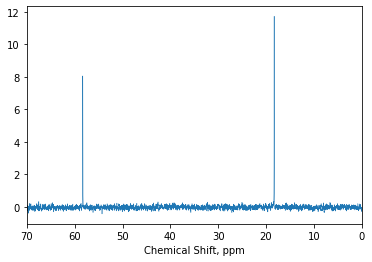

In [283]:
plt.plot(nmr[:,0], nmr[:,1], lw=0.5)
plt.xlabel('Chemical Shift, ppm')
plt.xlim(70, 0)

In [284]:
ir = np.genfromtxt('data/IR_acetone.csv', delimiter=',')

(4000.0, 600.0)

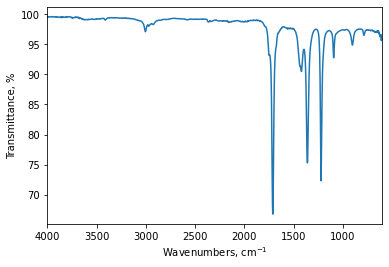

In [285]:
plt.plot(ir[:,0], ir[:,1])
plt.xlabel('Wavenumbers, cm$^{-1}$')
plt.ylabel('Transmittance, %')
plt.xlim(4000, 600)

NMR resonances are positive peaks while IR stretches are represented here as negative peaks, so we can find the largest features in both spectra by finding the maximum value in the NMR spectrum and the smallest value in the IR spectrum. 

In [286]:
np.max(nmr[:,1])

11.7279863357544

In [287]:
np.min(ir[:,1])

66.80017

These functions output the max and min values of the independent variable ($y$-axis). If we want to know the location on the $x$-axes, we need to use the NumPy functions `np.argmax()` and `np.argmin()` which return the indices of the max or min values instead of the actual value (“arg” is short for *argument*). 

In [288]:
imax = np.argmax(nmr[:,1])
imax

5395

In [289]:
imin = np.argmin(ir[:,1])
imin

2302

With the indices, we can extract the desired information using indexing of the $x$-axes. Below, the largest peak in the NMR spectrum is at 18.3 ppm while the smallest transmittance (i.e., largest absorbance) is at 1710 cm$^{-1}$ in the IR spectrum.

In [290]:
nmr[imax, 0]

18.312606267778

In [291]:
ir[imin, 0]

1710.068

Below, these values are plotted on the spectra as orange dots to validate that they are indeed the largest features in the spectra. 

(70.0, 0.0)

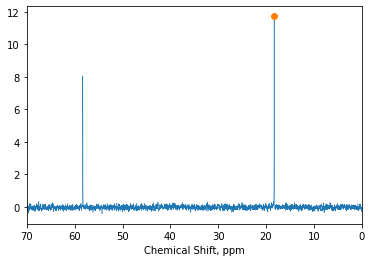

In [292]:
plt.plot(nmr[:,0], nmr[:,1], lw=0.5)
plt.plot(nmr[imax,0], nmr[imax,1], 'o')
plt.xlabel('Chemical Shift, ppm')
plt.xlim(70,0)

Text(0, 0.5, 'Transmittance, %')

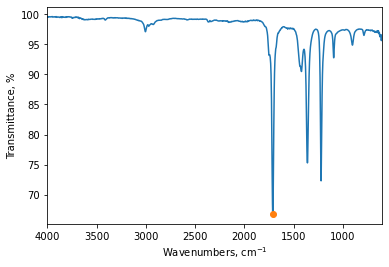

In [293]:
plt.plot(ir[:,0], ir[:,1])
plt.plot(ir[imin, 0], ir[imin, 1], 'o')
plt.xlim(4000, 600)
plt.xlabel('Wavenumbers, cm$^{-1}$')
plt.ylabel('Transmittance, %')

Both of these functions find the *global extremes* (or *global extrema*). If all you need is the largest feature in a spectrum, this works just fine. To find multiple features, we will need to find the local extrema addressed in the following section.

(6.1.2)=
### 6.1.2 Local Maximums & Minimums

A considerable amount of data in science contain numerous peaks and negative peaks which are called *local extrema*. To locate the multiple max and min values, we will use SciPy’s relative max/min functions `argrelmax()` and `argrelmin()`. These functions determine if a point is a max/min by checking a range of data points on both sides to see if the point is the larges/smallest. The range of data points examined is known as the window, and the window can be modified using the `order` argument. Instead of the actual max/min values, these functions return the indices as the “arg” part of the name suggests.

In [294]:
from scipy.signal import argrelmax, argrelmin

In [295]:
imax = argrelmax(nmr[:,1], order=2000)
imax

(array([1219, 5395]),)

The `argrelmax()` function returned two indices as an array wrapped in a tuple. If we plot the maxima marked with dots, we see that the function correctly identified both peaks.

(70.0, 0.0)

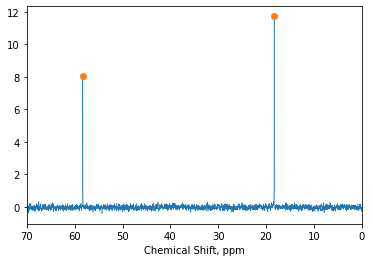

In [296]:
plt.plot(nmr[:,0], nmr[:,1], lw=0.5)
plt.plot(nmr[imax, 0], nmr[imax, 1], 'C1o')
plt.xlabel('Chemical Shift, ppm')
plt.xlim(70,0)

The `argrelmax()` function may at times identify an edge or a point in a flat region as a local maximum because there is nothing larger near it. There are multiple ways to mitigate these erroneous peaks. First, we can increase the window for which the function checks to see if a point is the largest value in its neighborhood. Unfortunately, making the window too large can also prevent the identification of multiple extrema near each other. The second mitigation is to change the function’s mode from the default `'clip'` to `'wrap'`. This makes the function treat the data as wrapped around on itself instead of stopping at the edge. That is, both edges of the data are treated as being connected. This makes it more likely that an extrema value is in the neighborhood. Finally, the user can filter the returned for values that correspond to peaks above a certain theshold value. Below is an example of filtering values based on a threshold. The window below is intentionally narrowed so that the `argrelmax()` function returns too many values for demonstration purposes.

In [297]:
imax = argrelmax(nmr[:,1], order=1000)[0]
imax

array([1219, 2860, 3943, 5395, 6613])

Next, we will create a boolean mask which is a series of `True` and `False` values indicating if the data point is above a threshold value or not. In this example, we are using `1` as a threshold, but another threhold value may be more appropriate for different data. This is accomplished below by using the boolean `>` operator. The `nmr[imax, 1]` indexes the identified peaks from above and only returns the height values as a result of the `1`. If the `1` was not included, we would get a collection of [ppm, height] pairs.

In [298]:
mask = nmr[imax, 1] > 1
mask

array([ True, False, False,  True, False])

Finally, we treat the mask of `True`/`False` values as if they are indicies to get only the values for legitimate peaks.

In [299]:
imax[mask]

array([1219, 5395])

(6.1.3)=
### 6.1.3 Slopes & Inflection Points

The slope is a useful feature as it can be used to identify inflection points, edges, and make subtle features in a curve more obvious. Noisy data can make it challenging to examine the slope as it causes the slope to fluctuate so much that it sometimes dwarfs the overall signal. It is recommended that the noise be first removed by signal smoothing covered in a section 6.2. To demonstrate the challenges, we will generate both noise-free and noisy synthetic data below and calculate the slopes.

In [300]:
x = np.linspace(0, 2*np.pi, 1000)
y_smooth = np.sin(x)
y_noisy = np.sin(x) + 0.07 * np.random.rand(len(x))

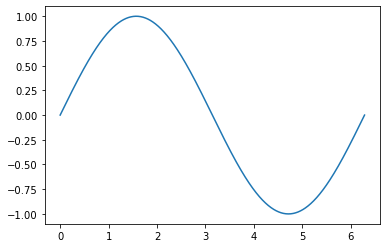

In [301]:
plt.plot(x, y_smooth)

We will use NumPy to calculate the slope using the `np.diff()` function which calculates the derivative of a user defined order (`n`). Because the slope is the *dy/dx* between every pair of adjacent points, the resulting slope data is one data point shorter than the original data. This is important when plotting the data because the length of the x and y values must be the same.

When taking the derivative, it is important to use smooth data. In the example below, the slope from the noise in the noisy data dwarfs that of the main signal. Therefore, we will use the derivative of the smooth data to find the inflection point below. 

In [302]:
dy_smooth = np.diff(y_smooth, n=1)
dy_noisy = np.diff(y_noisy, n=1)
x2 = (x[:-1] + x[1:]) / 2 # x values one shorter

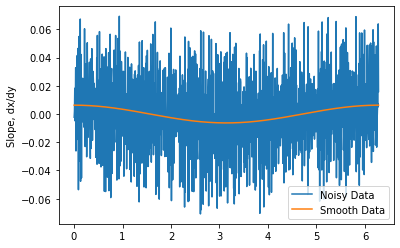

In [303]:
plt.plot(x2, dy_noisy, label='Noisy Data')
plt.plot(x2, dy_smooth, label='Smooth Data')
plt.ylabel('Slope, dx/dy')
plt.legend()

Because the inflection point in the center of the data has a negative slope, we will need to find the minimum slope. This may not always be the case with other data.

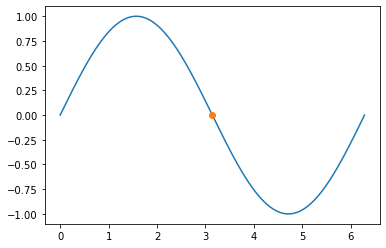

In [304]:
i = np.argmin(dy_smooth)  # finds min slope
plt.plot(x, y_smooth)
plt.plot(x[i], y_smooth[i], 'o')

(6.2)=
## 6.2 Smoothing Data

It is not uncommon to collect signal data that has a considerable amount of noise in it. Smoothing the data can help in the processing and analysis of the data such as making it easier to identify peaks or preventing the noise from hiding the extremes in the derivative of the data. Smoothing alters the actual data, so it is important to be transparent to others that the data were smoothed and how they were smoothed.

There are a variety of ways to smooth data including moving averages, band filters, and the Savitzky-Golay filter. We will focus on moving averages and Savitzky-Golay here. For this section, we will work with synthetic data with random noise generated below.

In [305]:
t = np.linspace(0, 10 * np.pi, 1000)
signal = np.sin(t)
noise = np.random.rand(1000)
data = signal + 0.7 * (noise - 0.5)

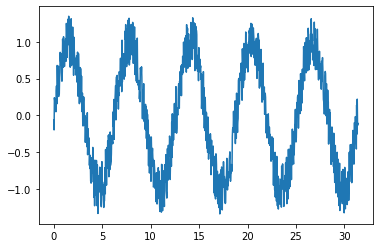

In [306]:
plt.plot(t, data)

(6.2.1)=
### 6.2.1 Unweighted Average

The first and simplest way to smooth data is to take the *moving average* of each data point with its immediate neighbors. This is an *unweighted sliding average smooth* or a *rectangular boxcar smooth*. From noisy data point $D_j$, we get smoothed data point $S_j$ by the following equation where $D_{j-1}$ and $D_{j+1}$ are the points immediately preceding and following a data point $D_j$, respectively.

$$ S_j = \frac{D_{j-1} + D_j + D_{j+1}}{3} $$

One thing to note about this smoothing method is that it is only valid for all points except the first and last because there are no data points both before and after them to take the average with. As a result, the smoothed data is two data points shorter. There are approximations that can be used to maintain the length of the data, but for simplicity, we will allow the data to shorten.

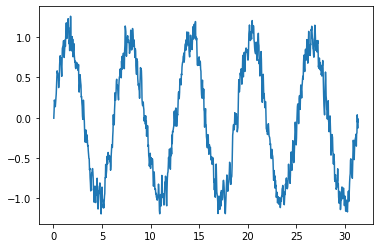

In [307]:
sum = data[:-2] + data[1:-1] + data[2:]
rect_smooth = sum / 3

plt.plot(t[1:-1], rect_smooth)

The data is smoothed relative to the original data, but there is still a considerable amount of noise present.

(6.2.2)=
### 6.2.2 Weighted Averages

The above method treats each point equally and only takes the average with the immediately adjacent data points. The *triangular smooth* approach averages extra data points with the points closer to the original point weighted more heavily than those further away. For example, if we take the average using five data points, this is described by the following equation.

$$ S_j = \frac{D_{j-2} + 2D_{j-1} + 3D_j + 2D_{j+1} + D_{j+2}}{9} $$

The resulting data is shortened by four points as the end points have insufficient neighbors to be averaged.

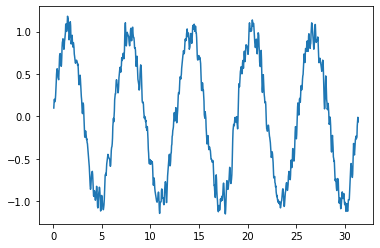

In [308]:
sum = data[:-4] + 2*data[1:-3] + 3*data[2:-2] + 2*data[3:-1] + data[4:]
tri_smooth = sum / 9

plt.plot(t[2:-2], tri_smooth)

The triangular smooth results in a smoother data set than the rectangular smooth. This is not surprising as applying the triangular smooth above is mathematically equivalent to applying the rectangular smooth twice. 

(6.2.3)=
### 6.2.3 Median Smoothing

While the above filters take some form of the mean of the surrounding data points, a median filter takes the median. This filter is sometimes applied to images because it reduces noise while maintaining sharp edges.

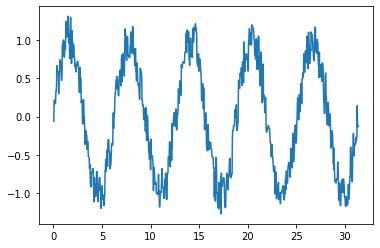

In [309]:
array2d = np.vstack((data[2:], data[1:-1], data[:-2]))
median_smooth = np.median(array2d, axis=0)

plt.plot(t[1:-1], median_smooth)

(6.2.4)=
### 6.2.4 Savitzky–Golay

Another approach is the *Savitzky–Golay* filter which incrementally moves along the noisy data and fits sections (i.e.., windows) of data points to a polynomial using least square minimization. While this approach had been previously described in the mathematical literature, Abraham Savitzky and M. J. E. Golay are known for applying it to spectroscopy ([https://doi.org/10.1021/ac60214a047](https://doi.org/10.1021/ac60214a047)). Conveniently, SciPy contains a built-in function for this called `savgol_filter()` from the `signal` module shown below.

~~~python
scipy.signal.savgol_filter(data, window, polyorder)
~~~

This function requires three arguments which include the original data as a NumPy array, `window` which is the width of the moving window the savgol algorithm fits to a polynomial, and `polyorder` which is the order of `polynomial` used for the moving data fit. You are encouraged to play with the `window` and `polyorder` arguments to see what works the best for your application. However, `polyorder` must be less than the `window` size, and the `window` must be an odd integer.

In [310]:
from scipy.signal import savgol_filter
sg_smooth = savgol_filter(data, 51, 3)

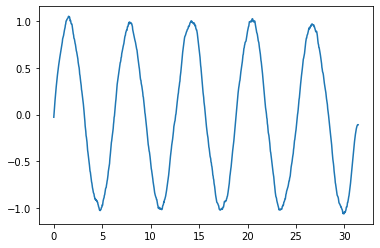

In [311]:
plt.plot(t, sg_smooth)

(6.3)=
## 6.3 Fourier Transforms

Another approach to filtering noise is to filter based on frequency. Many times, random noise in data occurs at a different frequency than the data itself, and the noise can be reduced by filtering noise frequency ranges while maintaining signal frequencies. If the noise is higher frequency than the signal, it can be filtered out with what is known as a *low-pass* filter. Alternatively, filtering out low-frequency noise is known as a *high-pass* filter, and filtering out noise above and blow the signal frequency is known as a *band-pass* filter. Frequency filtering is somewhat involved being that we need to use window functions which are covered in the [Think DSP](https://greenteapress.com/wp/think-dsp/) book by Allen Downey listed at the end of this chapter. Instead, we will just look at the distribution of signal and noise frequencies in synthetic data. This is useful for analyzing the noise in data and also is used routinely in nuclear magnetic resonance (NMR) spectroscopy and Fourier Transform infrared spectroscopy (FTIR).
    
To convert the data from the time domain to the frequency domain, we will use the *fast Fourier transform (FFT)* algorithm. This algorithm is only for data that is periodic.  Below, synthetic data is generated oscillating at 62.0 Hz with some random noise to make it more interesting.

In [312]:
t = np.linspace(0,1,1000)
freq = 62.0  # Hz
signal = np.sin(freq*2*np.pi*t)
noise = np.random.rand(1000)
data = signal + 0.5 * noise

Text(0.5, 0, 'Time, s')

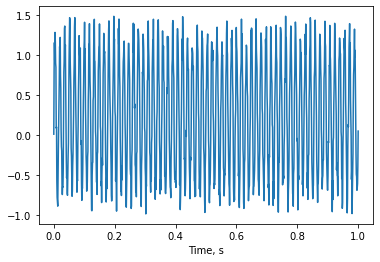

In [313]:
plt.plot(t, data)
plt.xlabel('Time, s')

SciPy contains an entire module called `fftpack` dedicated to Fourier transforms and reverse Fourier transforms. We will use the basic `fft()` function for our synthetic data which returns a mixture of real and imaginary values. For plotting, we will simply look at the real component of the result using `.real`.

Text(0.5, 0, 'Frequency, Hz')

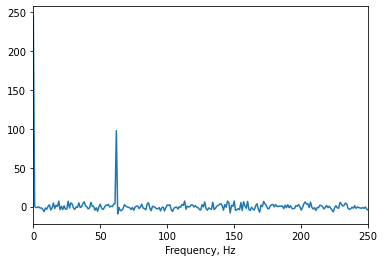

In [314]:
from scipy.fftpack import fft
fdata = fft(data)
plt.plot(fdata.real)
plt.xlim(0,500/2)
plt.xlabel('Frequency, Hz')

Only the first half of the Fourier transform output is plotted above because the second half is a mirror image of the first. A single peak at 62.0 Hz is present from our signal. The rest of the baseline of the plot is not smooth because there is noise present at a variety of frequencies. It is important to note that the erratic variations in the baseline of the frequency plot is not the noise itself but more like a histogram of all the frequencies present in the original data.

(6.4)=
## 6.4 Fitting & Interpolation

Signal data or information taken from signal data often conforms to linear, polynomial, or other mathematical trends, and fitting data is important because it allows scientists to determine the equation describing the physical or chemical behavior of the data. In *data fitting*, the user provides the data and the general class of equation expected, and the software returns the *coefficients* for the equation. *Interpolation* is the method of predicting values in regions among known data points. The calculation of values where no data was collected can be accomplished by either using the coefficients derived from a curve fit or using a special interpolation function that generates a callable function to calculate the new data points. Both approaches are demonstrated below.

Before we can do our fitting, we need some new, noisy data to examine. A linear set of data with added noise is generated below along with a second-order curve with the noise.

In [315]:
np.random.seed(18) #hidden cell in Jupyter Book

In [316]:
x = np.linspace(0,10,100)
noise = np.random.rand(100)
y_noisy = 2.2 * x + 3 * noise
y2_noisy = 3.4 * x**2 + 4 * x + 7 + 3 * noise

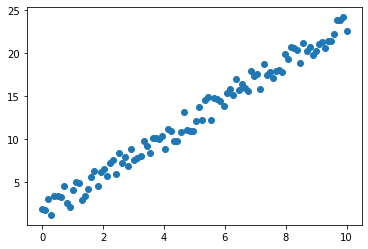

In [317]:
plt.scatter(x, y_noisy)

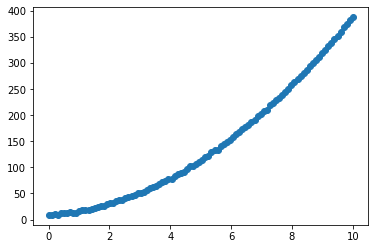

In [318]:
plt.scatter(x, y2_noisy)

(6.4.1)=
### 6.4.1 Linear Regression

Now we can fit the noisy linear data with a line using the NumPy `np.polyfit(x, y, degree)` function. The function takes the `x` and `y` data along with the `degree` of the polynomial. 

A line is a first-degree polynomial, and the function returns an array containing the coefficients for the fit with the highest order coefficients first. This is effectively a *linear regression*.

In [319]:
a, b = np.polyfit(x, y_noisy, 1)
print((a, b))

(2.166374725246873, 1.664367317070192)


For a linear equation of the form $y = ax + b$, we get an array of the form `array([a, b])`, so the fitted equation above is $y = 2.17x + 1.66$. The positive shift of the $y$-intercept above zero is not surprising being that we added random noise not centered around zero; the average of our `np.random.rand()` noise should be around 0.5, not zero. This could be remedied either by subtracting 0.5 from the noise or using another random number generator such as the normal distribution, such as `randn()`, which is centered around zero. 

We can view our linear regression by plotting a line on top of our data points using the coefficients found above.

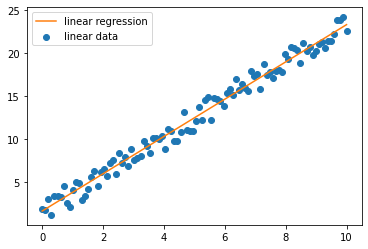

In [320]:
y_reg = a*x + b

plt.scatter(x, y_noisy, label='linear data')
plt.plot(x, y_reg, 'C1-', label='linear regression')
plt.legend()

We can also obtain the statistics for our fit using the `linregress()` function from the SciPy `stats` module. Note that this does not return the $r^2$ value but instead the $r$-value which can be squared to generate the $r^2$ value.

In [321]:
from scipy import stats
stats.linregress(x, y_noisy)

LinregressResult(slope=2.166374725246872, intercept=1.6643673170701927, rvalue=0.9905260665447096, pvalue=2.5626043628760627e-86, stderr=0.03033917262528924, intercept_stderr=0.17560506928107436)

```{note}
We are starting to see examples of functions that return multiple values which can be assigned to multiple variables using [tuple unpacking](2.1.3) like below.

$$ x, y = func(z) $$

There may be times when you don't need all of the returned values from a function. In these instances, it is common to use `__` (double underscore) as a junk variable which is broadly understood to store information that will never be used in the code. You may also see a `_` (single underscore) used for this purpose, but this is discouraged as a single underscore is also used by the Python interpreter to store the last ouput.
```

(6.4.2)=
### 6.4.2 Polynomial Fitting

Fitting to a polynomial of a higher order works the same way except that the order is above one. You will need to already know the order of the polynomial, or you can make a guess and see how well a particular order fits the data. Below, the `np.polyfit()` function determines the second-order data can be fit by the equation $y = 3.40x^2 + 3.95x + 8.70$. We can again plot this fit equation over our data points to see how well the data agree with our equation.

In [322]:
a, b, c = np.polyfit(x, y2_noisy, 2)
print((a, b, c))

(3.4018569590073064, 3.9478051351737853, 8.69500401449719)


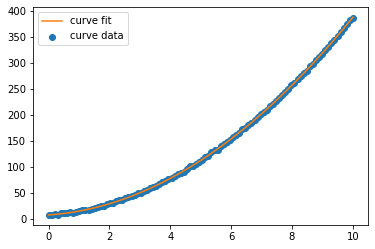

In [323]:
y_fit = a*x**2 + b*x + c

plt.scatter(x, y2_noisy, label='curve data')
plt.plot(x, y_fit, 'C1-', label='curve fit')
plt.legend()

(6.4.3)=
### 6.4.3 Interpolation

The practical difference between the `np.polyfit` function and the interpolation functions in SciPy is that the former returns coefficients for the equation while the interpolation functions return a Python function that can be used to calculate values. There are times when one is more desirable than the other depending upon your application. Below we will use the interpolation function to interpolate a one dimensional function.

Below is a dampening sine wave that we will interpolate from ten data points. 

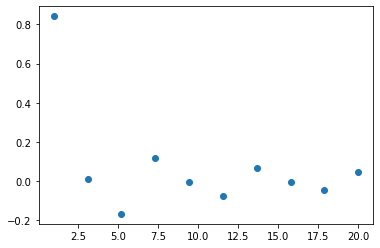

In [324]:
x = np.linspace(1,20, 10)
y = np.sin(x)/x
plt.plot(x,y, 'o')

To interpolate this one-dimensional function, we will use the `interp1d()` method from SciPy. Along with the `x` and `y` values, `interp1d()` requires a mode of interpolation using the kind keyword which can include the items listed in Table 2.

**Table 2** Modes for `interp1d()` Method

| Kind | Description |
|:----:| :---------- |
|`linear()` | Linear interpolation between data points |
|`zero()` | Constant value until the next data point |
|`nearest()` | Predicts values equaling the closest data point |
|`quadratic()` | Interpolates with a second-order spline |
|`cubic()` | Interpolates with a third-order spline |

Below is a demonstration of both linear and cubic interpolation. The two functions `f()` and `f2()` are generated and can be used like any other Python function to calculate values.  

In [325]:
from scipy import interpolate
f = interpolate.interp1d(x, y, kind='linear')
f2 = interpolate.interp1d(x, y, kind='cubic')

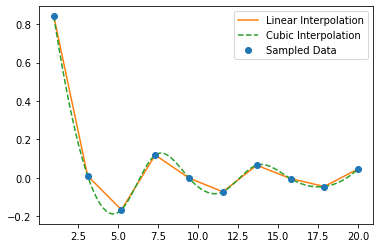

In [326]:
xnew = np.linspace(1,20,100)

plt.plot(xnew, f(xnew), 'C1-', label='Linear Interpolation')
plt.plot(xnew, f2(xnew), 'C2--', label='Cubic Interpolation')
plt.plot(x,y, 'o', label='Sampled Data')
plt.legend()

## Further Reading

The ultimate authority on NumPy and SciPy are the Numpy & SciPy Documentation page listed below. As changes and improvements occur in these libraries, this is one of the best places to find information. For information on digital signal processing (DSP), there are numerous sources such as Allen Downey's Think DSP book or articles such as those listed below.

1. Numpy and Scipy Documentation. [https://docs.scipy.org/doc/](https://docs.scipy.org/doc/) (free resource)

2. Downey, Allen B. Think DSP, Green Tea Press, 2016. [http://greenteapress.com/wp/think-dsp/](https://docs.scipy.org/doc/) (free resource)

3. O’Haver, T. C. An Introduction to Signal Processing in Chemical Measurement. *J. Chem. Educ.* **1991,** 68 (6), A147-A150. [https://doi.org/10.1021/ed068pA147](https://doi.org/10.1021/ed068pA147)

4. Savitzky, A.; Golay, M.J.E. Smoothing and Differentiation of Data by Simplified Least Squares Procedures. *Anal. Chem.* **1964,** 36 (8) 1627–1639. [https://doi.org/10.1021/ac60214a047](https://doi.org/10.1021/ac60214a047)

## Exercises

Complete the following exercises in a Jupyter notebook. Any data file(s) refered to in the problems can be found in the **data** folder in the same directory as this chapter's Jupyter notebook.

1. Import the file **CV_K3Fe(CN)6.csv** which contains a cyclic voltammogram for potassium cyanoferrate. Plot the data with the green dots on the highest point(s) and red triangles on the lowest point(s).

2. Import the file titled **CV_K3Fe(CN)6.csv** and determine the inflection points. Plot the data with a marker on both inflection points. Hint: There are two inflections points in these data with one running in the reverse direction making it have a negative slop.

3. Generate noisy synthetic data from the following code.

    ~~~python        
    from scipy.signal import sawtooth
    import numpy as np
    t = np.linspace(0, 4, 1000)
    sig = sawtooth(2 * np.pi * t) + np.random.rand(1000)
    ~~~

    a) Smooth the data using moving averages and plot the smoothed signal. Feel free to use the moving averages code from this chapter.
    
    b) Smooth the same data using a Savitzky–Golay filter. Plot the smoothed signal.
    
4. Import the $^{31}$P NMR file titled **fid_31P.csv** and determine the number of major frequencies are in this wave. Keep in mind that there will be a second echo for each peak.

5. The wavelength of emitted light ($\lambda$) from hydrogen is related to the electron energy level transitions by the following equation where R$_\infty$ is the Rydberg constant, n$_i$ is the initial principle quantum number of the electron, and n$_f$ is the final principle quantum number of the electron.

    $$ \frac{1}{\lambda} = R_\infty \left(\frac{1}{n_f^2} - \frac{1}{n_i^2} \right) $$
    
    The following is experimental data of the wavelengths for five different transitions from the  Balmer series (i.e., n$_f$ = 2).
    
    | Transition ($n_i$ $\rightarrow$ $n_f$) | Wavelength (nm) |
    | :--------:   |  :------: |
    | 3 $\rightarrow$ 2 | 656.1 |
    |4 $\rightarrow$ 2 | 485.2 |
    | 5 $\rightarrow$ 2 | 433.2 |
    | 6 $\rightarrow$ 2 | 409.1 |
    | 7 $\rightarrow$ 2 | 396.4 |
    
    ~~~python
    n_i = [3, 4, 5, 6, 7]
    wl = [656.1, 485.2, 433.2, 409.1, 396.4]
    ~~~    
    
    Calculate a value for the Rydberg constant (R$_\infty$) using a linear fit of the above data. The data will need to be first linearized.

6. The following data is for the initial rate of a chemical reaction for different concentrations of starting material (A). Calculate a rate constant (k) for this reaction using a nonlinear fit.

    | Conc A (M)  | Rate (M/s) |
    | :----:       | :-----:    |
    |  0.10 | 0.0034 |
    |  0.16 | 0.0087 |
    |  0.20 | 0.014  |
    |  0.25 | 0.021  |
    |  0.41 | 0.057  |
    |  0.55 | 0.10   |
    
    ~~~python
    conc = [0.10, 0.16, 0.20, 0.25, 0.41, 0.55]
    rate = [0.0034, 0.0087, 0.0136, 0.0213, 0.0572, 0.103]
    ~~~
    
7. A colorimeter exhibits the following absorbances for known concentrations of Red 40 food dye. Generate a calibration curve using the data below and then calculate the concentration of Red 40 dye in a pink soft drink with an absorbance of 0.481.

    | Absorb.  (@ 504 nm) | Red 40 (10$^{-5}$ M) | 
    | :----:     |  :-----:   |
    | 0.125 | 0.150 |
    | 0.940 | 1.13 |
    | 2.36 | 2.84 |
    | 2.63 | 3.16 |
    | 3.31 | 3.98 |
    | 3.77 | 4.53 |
    
    ~~~python
    ab = [0.125, 0.940, 2.36, 2.63, 3.31, 3.77]
    conc = [0.150, 1.13, 2.84, 3.16, 3.98, 4.53]
    ~~~
    
8. The following are points on the 2s radial wave function ($\Psi$) for a hydrogen atom with respect to the radial distance from the nucleus in Bohrs ($a_0$). Visualize the radial wave function as a smooth curve by interpolating the following data points.

    | Radius ($a_0$) | $\Psi$  |
    | :------:       | :----:  |
    |1.0 | 0.21 |
    |5.0 | -0.087 |
    |9.0 | -0.027 |
    |13.0 | -0.0058 |
    |17.0 | -0.00108 |
    
    ~~~python
    radius = [1.0, 5.0, 9.0, 13.0, 17.0]
    psi = [0.21, -0.087, -0.027, -0.0058, -0.00108]
    ~~~
    
9. The file **Cp2Fe_Mossbauer.txt** contains Mossbauer data for a ferrocene complex where the left data column is velocity in millimeters per second and the right column is relative transmission. Using Python, determine the velecities of the six negative peaks. Plot the spectrum with dots on lowest point of each negative peak, and be sure to label your axes complete with units.

10. Load the file **XRF_Cu.csv**, which contains X-ray fluorence (XRF) data for elemental copper, and use Python to determine the energy in eV of the two peaks. Notice that the *x*-axis is not in eV yet (see row 17 of data). You are advised to load the data using a pandas function, and setting a threshold will likely be neccesary. 